In [1]:
import zipfile as zp
import pandas as pd
#from pypac import PACSession as Session #or use requests below if non-ONS
from requests import Session
from io import BytesIO
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Creating Summary Prescription Data for Scotland

This code has been created to work with 2016, 2017 and 2018 data, earlier data may have format inconsistencies that need to be dealt with.

# Set File Location of Prescribing Data

These files are the "Prescriptions in the Community" .csv files that come from: https://www.opendata.nhs.scot/dataset/prescriptions-in-the-community

In [17]:
# Path to zip files
path = r"[CHANGE THIS PATH]\Scotland\\"

# Read in drug data

In [25]:
# Get drug data (NB some drugs duplicated for illnesses)
drug_data = pd.read_csv(path + r"..\drug_list.csv")

# Process Prescribing Data

This code iterates over the monthly prescribing data, ultimately producing an aggregate table.

Note, if you want to find prescribing for non-loneliness related diseases, all you need to do is provide a different set of drug_data and edit the code_loneliness function.

**Filename format:** pitc[year][month].csv (e.g. pitc201801.csv)

**Columns:** HBT2014, GPPractice, BNFItemCode, BNFItemDescription, ClassOfPreparationCode, NumberOfPaidItems, PaidQuantity, GrossIngredientCost, PaidDateMonth

In [37]:
# column names
col_bnfname = "BNFItemDescription"
col_items = "NumberOfPaidItems"

In [38]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x[col_bnfname].str.contains("|".join(drug_data['medication'].unique()),
                                                  case = False, 
                                                  regex = True).astype('int16')
    # Return dataframe multiplied by counts of items.
    return out.multiply(x[col_items], axis=0)

In [39]:
# Make dictionary for aggregation
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
agg_cols['loneliness'] = 'sum'
for key in ['Date', 'HBT2014']:
    agg_cols[key] = 'first'

In [40]:
monthly_data = []

for file in os.listdir(path + "Prescriptions"):
    # Open prescribing files in pandas.
    prescribe = pd.read_csv(path + "Prescriptions\\" + file)
    prescribe.columns = prescribe.columns.str.strip()
    # Rename 'PaidDateMonth' column to 'date'
    prescribe.rename(columns = {'PaidDateMonth': 'Date'}, inplace = True) 
    # Get counts of prescribing dataframe for loneliness related diseases
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    # merge dataframes
    prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
    del loneliness_prescribing

    # merge in address information
    #prescribe = prescribe.merge(addr, left_on = 'PracticeID', right_on = 'PracticeId')
    #del addr

    # Create uniform postcode field
    #prescribe['pcstrip'] = prescribe['Postcode'].str.replace("\s","")

    # get a summary - grouping by GPPractice
    summary = prescribe.groupby('GPPractice', as_index=False).agg(agg_cols)
    del prescribe

    monthly_data.append(summary)
    print(file)


pitc201801.csv
pitc201802.csv
pitc201803.csv
pitc201804.csv
pitc201805.csv
pitc201806.csv
pitc201807.csv
pitc201808.csv
pitc201809.csv
pitc201810.csv
pitc201811.csv
pitc201812.csv


In [41]:
# concatenate all the monthly data together.
data = pd.concat(monthly_data, ignore_index = True)

In [47]:
data[data["loneliness"] > 0].head()

,GPPractice,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,Date,HBT2014
0,10002,508,21,691,693,61,431,46,0,3,9060,1760,201801,S08000027
1,10017,527,36,625,630,80,373,72,2,2,9557,1720,201801,S08000027
3,10036,289,21,450,452,50,285,50,1,1,5677,1148,201801,S08000027
4,10106,493,23,754,759,97,516,60,1,7,9834,1949,201801,S08000027
5,10125,318,20,485,489,76,341,34,2,5,6662,1280,201801,S08000027


In [44]:
# Save aggregated data
data.to_csv(path + "processed_data.csv")

# Import GP Practices

## Use only General Practice surgeries

Use the 'GP Practice Contact Details and List Sizes' data from: https://www.opendata.nhs.scot/dataset/gp-practice-contact-details-and-list-sizes to get GP surgery codes and number of registered patients.

Note that Scotland only publishes these data four times a year (in Jan, Apr, Jul and Oct) - so we'll just use the previous quarter's numbers until the next quarter (e.g. use Jan 18 data for Jan/Feb/Mar)

**Filename format:** gppractices[year][month][day].csv (e.g. gppractices20180101.csv)

**Columns:** PracticeCode, PracticeName, PracticeListSize, AddressLine1, AddressLine2, AddressLine3, AddressLine4, Postcode, TelephoneNumber, PracticeType, Dispensing, HB2014 [Health Board], HB1995 [Health Board], HSCP2016 [Health and Social Care Partnership], CA2011 [Council Area], DZ2011 [Data Zone], DZ2001 [Data Zone]

In [21]:
data = pd.read_csv(path + "processed_data.csv", index_col = 0)

In [21]:
# Get GP files
gp_path = path + r"GP data\\"

In [53]:
gp_combine = []

for file in os.listdir(gp_path):
    # read file into pandas
    date = file[-12:-6]
    year = date[:4]
    month = date[4:]
    
    # Deal with different file structures
    gp_data = pd.read_csv(gp_path + file)
    #gp_data.columns = gp_data.columns.str.upper().str.replace(" ","_")
    gp_data = gp_data.rename(columns = {'PracticeCode': 'GPPractice'})
    gp_data['Date'] = year + month
    gp_combine.append(gp_data[['Date','GPPractice','Postcode','PracticeListSize']])
    print(file)

gppractices20180101.csv
gppractices20180201.csv
gppractices20180301.csv
gppractices20180401.csv
gppractices20180501.csv
gppractices20180601.csv
gppractices20180701.csv
gppractices20180801.csv
gppractices20180901.csv
gppractices20181001.csv
gppractices20181101.csv
gppractices20181201.csv


In [54]:
# concatenate all the gp data together.
gp_data = pd.concat(gp_combine, ignore_index = True)

In [55]:
gp_data.head()

,Date,GPPractice,Postcode,PracticeListSize
0,201801,10002.0,DD2 5NH,7484.0
1,201801,10017.0,PH7 3SA,6685.0
2,201801,10036.0,PH15 2BL,4593.0
3,201801,10106.0,DD5 1DU,6102.0
4,201801,10125.0,PH11 8EQ,4245.0


In [56]:
# Get the unique codes for GP surgeries and subset the prescribing data according to these codes.
gp_ids = gp_data['GPPractice'].unique()
data = data[data['GPPractice'].isin(gp_ids)].copy()
data.shape

(11446, 14)

In [57]:
# Make date a datetime variable
gp_data['Date'] = pd.to_datetime(gp_data['Date'], format = '%Y%m')

In [58]:
# Make date a datetime variable - days are assigned as first day of the month.
data['Date'] = pd.to_datetime(data['Date'], format = '%Y%m')

In [59]:
# Merge on the basis of date and PracCode - produces some nulls for counts.
# It may be possible to predict missing values using a time-series model.
data = data.merge(gp_data, how = 'left', on = ['Date','GPPractice'])

In [61]:
# Save aggregated data
data.to_csv(path + "processed_data_with_GPs.csv")

# Add Postcode Location

Postcode location is pulled in from the latest ONS NSPL (National Statistics Postcode Lookup). There is a guide to fields here: http://geoportal.statistics.gov.uk/datasets/0a404beab6f544be8fb72d0c2b12d62b

NB - If using an ONS laptop `pip install pypac`, if not comment pypac import above and use requests.

In [9]:
data = pd.read_csv(path + "processed_data_with_GPs.csv", index_col=0)

In [62]:
# Read in postcode lookup data
# This is the persistent link to the latest ONS NSPL
postcode_url = "http://geoportal.statistics.gov.uk/datasets/055c2d8135ca4297a85d624bb68aefdb_0.csv"

with Session() as session:
    response = session.get(postcode_url, verify = False)

field_dtypes = {'objectid': 'int32', 'pcd':'str', 'pcd2': 'str', 'pcds':'str', 'dointr':'str','doterm':'str',
                'usertype':'int8','oseast1m': 'float', 'osnorth1m': 'float', 'osgrdind':'int8', 'lat':'float', 
                'long':'float', 'X':'float', 'Y':'float', 'imd': 'int8',
                'oa11':'str', 'cty': 'str', 'ced':'str', 'laua': 'str', 'ward': 'str', 'hlthau':'str',
                'ctry': 'str','pcon': 'str','eer': 'str','teclec': 'str','ttwa': 'str','pct': 'str','nuts': 'str',
                'park': 'str','lsoa11': 'str','msoa11': 'str','wz11': 'str','ccg': 'str','bua11': 'str',
                'buasd11': 'str','ru11ind': 'str','oac11': 'str','lep1': 'str','lep2': 'str','pfa': 'str',
                'ced': 'str','nhser': 'str','rgn': 'str','calncv': 'str','stp': 'str'}

pc = pd.read_csv(BytesIO(response.content), dtype = field_dtypes)    

In [63]:
# create pcstrip for matching
pc['pcstrip'] = pc['pcd'].str.replace("\s","")

NB - here I'm joining 2011 LSOA, 2011 MSOA, Rural-Urban Indicator, Region (formally GOR), Local Authority Area (effectively district), and IMD score (NB separate for each country). However, you can add any of the geography codes available in the NSPL.

In [64]:
# Create uniform postcode field
data['pcstrip'] = data['Postcode'].str.replace("\s","")

In [65]:
data_temp = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                       how = 'left',
                       on = 'pcstrip')

In [66]:
# Check for missing postcodes
data_temp[data_temp['oseast1m'].isnull()]['pcstrip'].value_counts()

Series([], Name: pcstrip, dtype: int64)

In [14]:
# no missing postcodes in Scotland
# new_pcs = {'DL154SB': 'DL54SB', 'WR59QT':'WR52QT', 'DN18QN':'DN48QN', 'HU32AE':'HU34AE','GL10QD': 'GL13NN',
#            'ME122TZ':'ME102TZ', 'BS378NG':'BS374NG', 'CV115PO':'CV115PQ', 'TW152EA':'TW153EA', 'EN24EJ':'EN80BX', 
#            'YO302JS':'YO306JA','L62UN':'L67UN', 'NG698DB':'NG98DA', 'HA24ES':'HA14ES'}

# data['pcstrip'] = data['pcstrip'].map(new_pcs).fillna(data['pcstrip'])

In [67]:
# Merge data
data = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                  how = 'left', 
                  on = 'pcstrip')

In [70]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcodes_GPs.csv")

## Check Postcodes 

Some Practice Codes have more than one postcode associated with them. Possible reasons for this are:
* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

There are 28 practices codes which have more than 1 postcode assigned to them, this is about 2.9% of unique practices.

All 28 practices have 2 postcodes associated with them.

3 of these practices fall within the same LSOA, 25 fall within 2 different LSOAs.

We'll ignore this for now - this will require some more advanced cleaning - useful to be aware of though.

In [71]:
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('GPPractice')['pcstrip'].unique().map(len)
# 28 practices have more than 1 postcode associated with it.
pc_prac_counts[pc_prac_counts > 1].count()

28

In [72]:
# Practice codes with multiple associated postcodes account forc. 2.9% of the data
pc_prac_counts[pc_prac_counts > 1].count()/len(pc_prac_counts)

0.029166666666666667

In [73]:
pc_prac_counts[pc_prac_counts > 1].value_counts()

2    28
Name: pcstrip, dtype: int64

In [74]:
# Count of these Practices falling within the same LSOA
(data[data['GPPractice'].isin(pc_prac_counts[pc_prac_counts > 1].index)]
 .groupby('GPPractice')['lsoa11']
 .unique()
 .map(len)
 .value_counts())

2    25
1     3
Name: lsoa11, dtype: int64

# Generate Statistics from Prescribing Counts

## Percentages At Postcode Level

Aggregate observations to postcodes and compute percentages for 'depression', 'alzheimers', 'blood pressure', 'hypertension', 'diabetes', 'cardiovascular disease', 'insomnia', 'addiction', 'social anxiety', and 'loneliness'.

## Outlier Removal

Should we remove some GPs on the basis that they have very low/high values which might indicate they are not accessible to the general population, and instead represent specialist services?

Currently, we won't do this, but it's an advanced task to look into.

## Standardise Percentages

Should we standardise within time points, or across them? Or standardise with GP practices or across them?

Can't standardize within GPs, as can't then compare between GPs.

Can't standardise across GPs within years, as can't then compare between years.

Can't standardise across GPs across years, as can't then disambiguate changes to rank order over time.

<u> First Step </u>

Take the average percentage of disease groups within postcodes annually - this is then an annual summary measure of prescribing by postcode. Aggregation entire depends on desired time frame for analysis.

NB, this is a mean of percentages - could also calculate an overall percentage by summing monthly counts by year and dividing through by monthly sum of items.

<u> Second Step </u>

z-score standardise for earliest year observed across GPs. Store mean and standard deviation.

z-score standardise subsequent years wrt baseline mean and standard deviation.

OR

Use min-max normalisation by year (decile normalisation?). This standardises the different percentages to the same range - although in theory they're comparable anyway...

## Aggregation and Percentages

In [75]:
data = pd.read_csv(path + "processed_data_with_postcodes_GPs.csv", index_col = 0)

In [77]:
data.dtypes

GPPractice                  int64
depression                  int64
alzheimers                  int64
blood pressure              int64
hypertension                int64
diabeties                   int64
cardiovascular disease      int64
insomnia                    int64
addiction                   int64
social anxiety              int64
NumberOfPaidItems           int64
loneliness                  int64
Date                       object
HBT2014                    object
Postcode                   object
PracticeListSize          float64
pcstrip                    object
oseast1m                  float64
osnrth1m                  float64
lsoa11                     object
msoa11                     object
ru11ind                   float64
rgn                        object
laua                       object
imd                       float64
dtype: object

In [78]:
# Make dictionary for aggregation
# counts to sum
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
agg_cols['loneliness'] = 'sum'
agg_cols['PracticeListSize'] = 'sum'

# Other data to preserve
for key in ['HBT2014', 'Postcode', 
            'oseast1m', 'osnrth1m', 'lsoa11', 'msoa11','ru11ind', 'rgn', 'laua', 'imd']:
    agg_cols[key] = 'first'

In [79]:
# Do aggregation and produce counts by postcode by date.
data = data.groupby(['pcstrip', 'Date'], as_index=False).agg(agg_cols)

In [80]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups
data[target_cols] = data[perc_cols].divide(data[col_items], axis=0) * 100

# Overall percentage for loneliness realted disease prescribing
data['loneliness_perc'] = data['loneliness'].divide(data[col_items], axis=0) * 100

## Standardisation (z-scores)

In [81]:
# Firstly aggregate percentages by postcodes by year.
#data['Year'] = data['Date'].dt.year
data['Year'] = 2018

# Aggregation
cols = {'PracticeListSize': 'mean', 'HBT2014': 'first', 'oseast1m':'first', 'osnrth1m':'first',
        'lsoa11': 'first', 'msoa11': 'first', 'ru11ind': 'first', 'rgn': 'first', 'laua':'first', 'imd': 'first',
        'depression_perc': 'mean', 'alzheimers_perc': 'mean', 'blood pressure_perc': 'mean', 'hypertension_perc': 'mean',
        'diabeties_perc': 'mean', 'cardiovascular disease_perc': 'mean', 'insomnia_perc': 'mean', 'addiction_perc': 'mean',
        'social anxiety_perc': 'mean', 'loneliness_perc': 'mean'}

data = data.groupby(['pcstrip','Year'], as_index=False).agg(cols)

In [82]:
# The mean value returns a value broadly in the centre of the distribution of respective disease classes.
# Therefore we'll go with an un-truncated arithmetic mean.
# Can always revisit this assumption later.

per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc', 'loneliness_perc']

# Get mean and std for baseline (2016)
mean_std = data[data['Year'] == 2018][per_cols].agg(['mean','std'])

In [83]:
# Make new column names.
std_cols = [col[:-4] + 'zscore' for col in per_cols]

zscores = []    
# z-score standardise for each year by baseline mean and std 
for year in [2016,2017,2018]:
    zscores.append((data.loc[data['Year'] == year, per_cols] - mean_std.loc['mean', per_cols]) / mean_std.loc['std', per_cols])

zscores = pd.concat(zscores).sort_index()
data[std_cols] = zscores

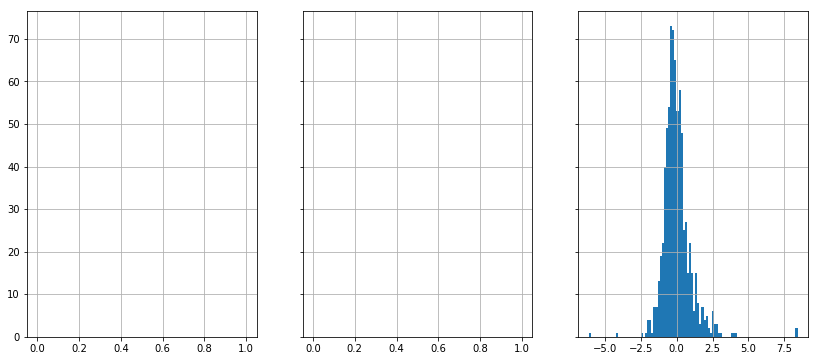

In [84]:
# plot zscores for loneliness
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
# These means are comparable as standardised using 2016 mean and std.
data[data['Year'] == 2016]['loneliness_zscore'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneliness_zscore'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneliness_zscore'].hist(bins=100, ax = ax3);

In [85]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcodes_GPs_stats.csv")

# Create Loneliness Variable

The actual loneliness variable we work with is the sum of the standardised scores of: depression, alzheimers, hypertension, insomnia, addiction and social anxiety, for each year of interest.

This means that the loneliness variable is actually an equally weighted index of the above domains.

In [86]:
# sum function ignores NAs
data['loneills'] =  data[['depression_zscore', 'alzheimers_zscore', 'hypertension_zscore', 'insomnia_zscore',
                          'addiction_zscore','social anxiety_zscore']].sum(axis=1)

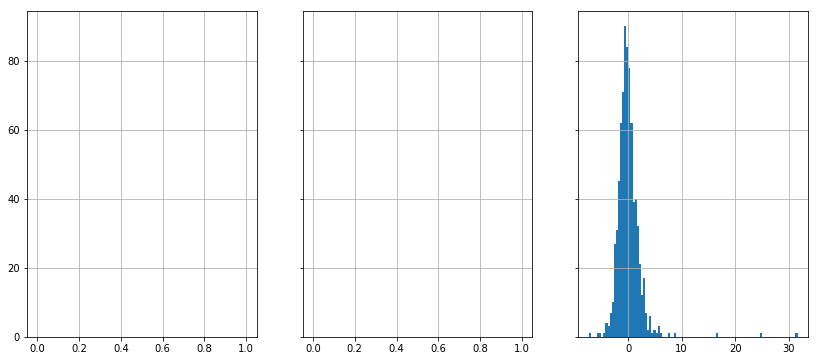

In [87]:
# plot zscores for loneills
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
data[data['Year'] == 2016]['loneills'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneills'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneills'].hist(bins=100, ax = ax3);

In [88]:
# Save aggregated data
data.to_csv(path + "final_data.csv")